In [345]:
import os
import datetime

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

from natsort import natsorted
from PIL import Image
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

In [87]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], diff_rgb = diff[:, :, 0] + diff[:, :, 1] + diff[:, :, 2]=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         x = F.adaptive_avg_pool2d(x, 1)
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
#         mu = x[:, :self.z_dim]
#         logvar = x[:, self.z_dim:]
#         return mu, logvar
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512


        self.layer4 = self._make_layer(BasicBlockDec, 512, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 256, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 128, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)
        self.convtrans1 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
#         x = self.linear(z)
#         x = x.view(z.size(0), 512, 1, 1)
#         x = F.interpolate(z, scale_factor=4)
        x = self.layer4(z)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
#         x = self.convtrans1(x)
        x = x.view(x.size(0), 3, 256, 256)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
#         mean, logvar = self.encoder(x)
        z = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, z
    
#     @staticmethod
#     def reparameterize(mean, logvar):
#         std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
#         epsilon = torch.randn_like(std)
#         return epsilon * std + mean

In [88]:
vae = VAE(z_dim=10).cuda()

In [89]:
summary(vae, (1, 3, 256, 256), depth=6)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [ResNet18Enc: 1, Conv2d: 2, BatchNorm2d: 2, MaxPool2d: 2, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockDec: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, BasicBlockDec: 3, Conv2d: 4, BatchNorm2d: 4, ResizeConv2d: 4, Conv2d: 5, BatchNorm2d: 4, Sequential: 4, ResizeConv2d: 5, Conv2d: 6, BatchNorm2d: 5]

In [98]:
INPUT_SHAPE = 256

In [147]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()
        
        self.convtrans1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=4)

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class
 
        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         x = F.adaptive_avg_pool2d(x, 1)
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
#         mu = x[:, :self.z_dim]
#         logvar = x[:, self.z_dim:]
#         return mu, logvar
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 256

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 32, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
#         x = self.linear(z)
#         x = x.view(z.size(0), 512, 1, 1)
#         x = F.interpolate(z, scale_factor=4)
        x = self.layer4(z)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, INPUT_SHAPE, INPUT_SHAPE)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
#         mean, logvar = self.encoder(x)
        z = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, z
    


In [148]:
vae = VAE(z_dim=10).cuda()
summary(vae, (1, 3, INPUT_SHAPE, INPUT_SHAPE), depth=6)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [ResNet18Enc: 1, Conv2d: 2, BatchNorm2d: 2, MaxPool2d: 2, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Sequential: 2, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, BasicBlockEnc: 3, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4]

In [138]:
enc = ResNet18Enc().cuda()
summary(enc, (1, 3, 256, 256), depth=6)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18Enc                              --                        --
├─Conv2d: 1-1                            [1, 64, 128, 128]         1,728
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─MaxPool2d: 1-3                         [1, 64, 64, 64]           --
├─Sequential: 1-4                        [1, 64, 64, 64]           --
│    └─BasicBlockEnc: 2-1                [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─Conv2d: 3-3                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 64, 64]           128
│    │    └─Sequential: 3-5              [1, 64, 64, 64]           --
│    └─BasicBlockEnc: 2-2                [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-6                  [1, 64, 64, 64]           36,8

In [176]:
class BasicBlockDec(nn.Module):

    def __init__(self, stride=1):
        super().__init__()
        
        self.convtrans1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.convtrans2 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1)



    def forward(self, x):
        out1 = self.convtrans1(x)
        out2 = torch.relu(self.bn2(out1))
        out2 = self.convtrans2(out2)
        out2 = torch.relu(self.bn2(out2))
        final = torch.add(out1, out2)
        
        return final

In [180]:
basic = BasicBlockDec().cuda()
print(type(basic))
summary(basic, (1, 512, 8, 8), depth=6)

<class '__main__.BasicBlockDec'>


Layer (type:depth-idx)                   Output Shape              Param #
BasicBlockDec                            --                        --
├─ConvTranspose2d: 1-1                   [1, 512, 16, 16]          4,194,816
├─BatchNorm2d: 1-2                       [1, 512, 16, 16]          1,024
├─ConvTranspose2d: 1-3                   [1, 512, 16, 16]          2,359,808
├─BatchNorm2d: 1-4                       [1, 512, 16, 16]          (recursive)
Total params: 6,555,648
Trainable params: 6,555,648
Non-trainable params: 0
Total mult-adds (G): 1.68
Input size (MB): 0.13
Forward/backward pass size (MB): 3.15
Params size (MB): 26.22
Estimated Total Size (MB): 29.50

In [335]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, shape):
        super().__init__()
        if shape == 512:
            shape2 = 512
        else:
            shape2 = int(shape * 2)
        
        self.convtrans1 = nn.ConvTranspose2d(shape2, shape, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(shape)
        self.convtrans2 = nn.ConvTranspose2d(shape, shape, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out1 = self.convtrans1(x)
        out2 = torch.relu(self.bn2(out1))
        out2 = self.convtrans2(out2)
        out2 = torch.relu(self.bn2(out2))
        final = torch.add(out1, out2)
        
        return final

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.layer1 = BasicBlockDec(512)
        self.layer2 = BasicBlockDec(256)
        self.layer3 = BasicBlockDec(128)
        self.layer4 = BasicBlockDec(64)
        self.conv1 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

#         self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, shape):
        return 
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         x = self.linear(z)
#         x = x.view(z.size(0), 512, 1, 1)
#         x = F.interpolate(z, scale_factor=4)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         x = self.conv1(x)

        x = torch.sigmoid(self.conv1(x))
#         x = x.view(x.size(0), 3, INPUT_SHAPE, INPUT_SHAPE)
        return x

class AutoEncoder(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)
        self.conv1 = nn.Conv2d(512, 512, kernel_size=1, stride=1)

    def forward(self, x):
#         mean, logvar = self.encoder(x)
        x = self.encoder(x)
        x = torch.relu(self.conv1(x))
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(x)
        return x
    


In [337]:
ae = AutoEncoder(z_dim=10).cuda()
summary(ae, (1, 3, INPUT_SHAPE, INPUT_SHAPE), depth=6)

Layer (type:depth-idx)                        Output Shape              Param #
AutoEncoder                                   --                        --
├─ResNet18Enc: 1-1                            [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         1,728
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-3                         [1, 64, 64, 64]           --
│    └─Sequential: 2-4                        [1, 64, 64, 64]           --
│    │    └─BasicBlockEnc: 3-1                [1, 64, 64, 64]           --
│    │    │    └─Conv2d: 4-1                  [1, 64, 64, 64]           36,864
│    │    │    └─BatchNorm2d: 4-2             [1, 64, 64, 64]           128
│    │    │    └─Conv2d: 4-3                  [1, 64, 64, 64]           36,864
│    │    │    └─BatchNorm2d: 4-4             [1, 64, 64, 64]           128
│    │    │    └─Sequential: 4-5              [1, 64, 64, 64]           --
│    │

In [381]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.0004

In [382]:
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [383]:

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
}

In [384]:
train_root = './cap_dataset/white_omote_crop/train/good/'  # train dataの保存してあるディレクトリ


In [385]:
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [386]:
model = AutoEncoder(z_dim=10).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                             weight_decay=1e-5)

In [387]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    for img in train_loader:
        img = Variable(img).cuda()
        
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, total_loss))
        


epoch [1/100], loss:0.1387
epoch [1/100], loss:0.2262
epoch [1/100], loss:0.2826
epoch [1/100], loss:0.3098
epoch [1/100], loss:0.3264
epoch [1/100], loss:0.3393
epoch [1/100], loss:0.3518
epoch [1/100], loss:0.3616
epoch [1/100], loss:0.3709
epoch [1/100], loss:0.3790
epoch [2/100], loss:0.0081
epoch [2/100], loss:0.0158
epoch [2/100], loss:0.0226
epoch [2/100], loss:0.0297
epoch [2/100], loss:0.0357
epoch [2/100], loss:0.0421
epoch [2/100], loss:0.0479
epoch [2/100], loss:0.0538
epoch [2/100], loss:0.0588
epoch [2/100], loss:0.0640
epoch [3/100], loss:0.0051
epoch [3/100], loss:0.0098
epoch [3/100], loss:0.0143
epoch [3/100], loss:0.0190
epoch [3/100], loss:0.0234
epoch [3/100], loss:0.0276
epoch [3/100], loss:0.0320
epoch [3/100], loss:0.0360
epoch [3/100], loss:0.0399
epoch [3/100], loss:0.0437
epoch [4/100], loss:0.0046
epoch [4/100], loss:0.0100
epoch [4/100], loss:0.0140
epoch [4/100], loss:0.0201
epoch [4/100], loss:0.0247
epoch [4/100], loss:0.0300
epoch [4/100], loss:0.0340
e

In [388]:
today = datetime.datetime.today()
today = today.strftime('%m%d%H%M')
pkl_path = "resnetAE_{}.pkl".format(today)

In [389]:
torch.save(model.state_dict(), pkl_path)

In [390]:
model = AutoEncoder(z_dim=10).cuda()
model.load_state_dict(torch.load(pkl_path))
model.eval()

AutoEncoder(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [420]:
test_root = './cap_dataset/white_omote_crop/test'

In [421]:
test_dataset = LoadFromFolder(test_root, transform=transform_dict["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [422]:
for img in test_loader:
    img = Variable(img).cuda()
    save_image_size_for_z = 4
    save_images = model(img)
    save_image(save_images[:save_image_size_for_z], "result.png", nrow=4)

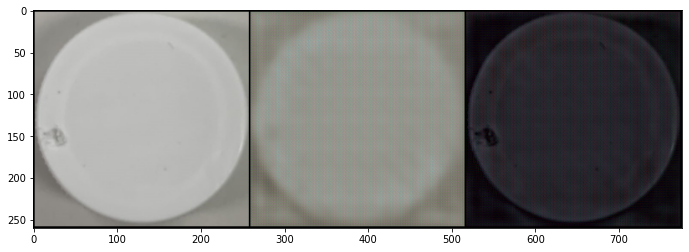

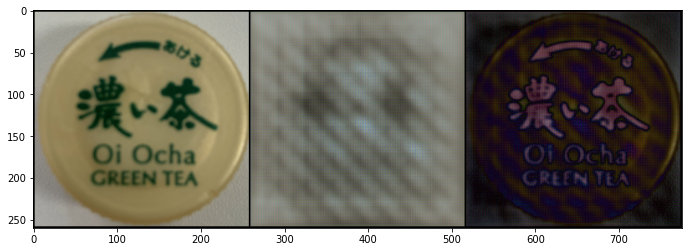

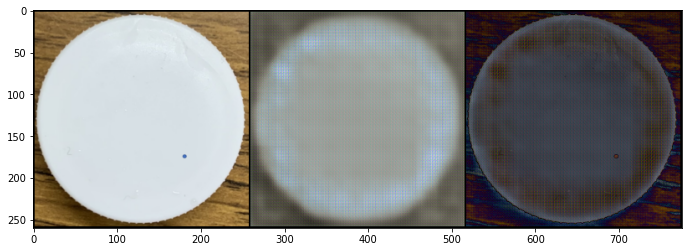

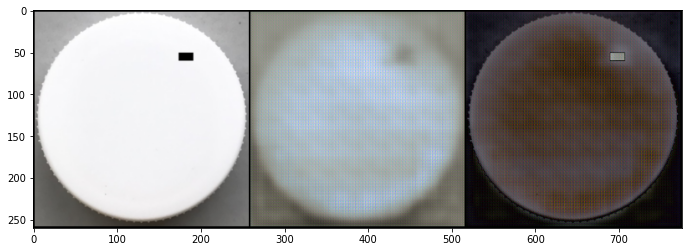

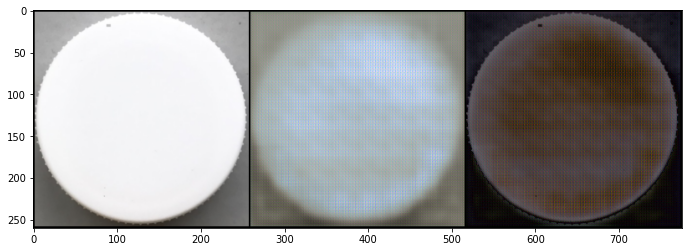

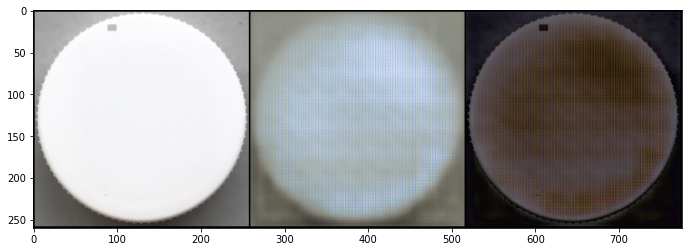

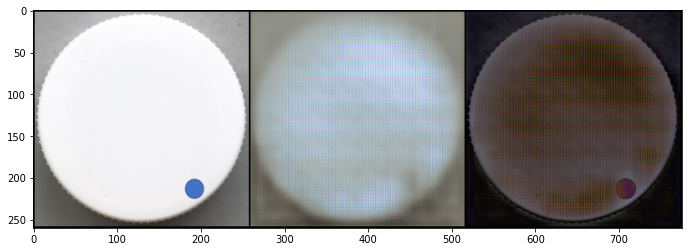

In [423]:
for idx in range(len(test_dataset)):

    x = test_dataset[idx].view(1, 3, 256, 256).cuda()
#     x = Variable(test_dataset[idx]).cuda()
    constructed = model(x)
    
#     loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - constructed)
#     print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), constructed.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()

In [424]:
diff_rgb = diff_img.squeeze()

In [425]:
from scipy import signal
import seaborn as sns


In [426]:
diff_rgb.shape

torch.Size([3, 256, 256])

In [427]:
diff_rgb = diff_rgb[0, :, :] + diff_rgb[1, :, :] + diff_rgb[2, :, :]

In [428]:
H = signal.convolve2d(diff_rgb.cpu().detach().numpy(), np.ones((4,4)), mode='same')

In [429]:
diff_img.cpu().detach().numpy().shape

(1, 3, 256, 256)

<AxesSubplot:>

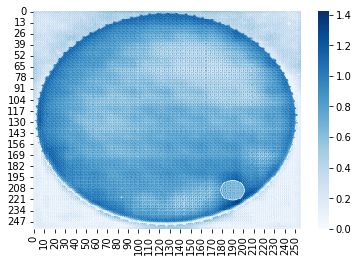

In [430]:
sns.heatmap(diff_rgb.cpu().detach().numpy(), cmap='Blues', vmin=0)

In [416]:
diff_img

tensor([[[[0.1251, 0.1781, 0.1103,  ..., 0.2197, 0.1661, 0.1301],
          [0.0809, 0.0554, 0.1316,  ..., 0.1716, 0.2520, 0.1953],
          [0.0530, 0.1134, 0.0211,  ..., 0.2340, 0.0768, 0.1414],
          ...,
          [0.0590, 0.0330, 0.1223,  ..., 0.2202, 0.2947, 0.2363],
          [0.0645, 0.0617, 0.1238,  ..., 0.2907, 0.1651, 0.2410],
          [0.0631, 0.0696, 0.0317,  ..., 0.2522, 0.2644, 0.2170]],

         [[0.0743, 0.0101, 0.0075,  ..., 0.0483, 0.0559, 0.0741],
          [0.0821, 0.0269, 0.0585,  ..., 0.0947, 0.0458, 0.0413],
          [0.0647, 0.0403, 0.0177,  ..., 0.0795, 0.0547, 0.0641],
          ...,
          [0.1166, 0.0316, 0.0920,  ..., 0.1095, 0.0761, 0.0810],
          [0.1859, 0.1844, 0.1789,  ..., 0.1315, 0.0840, 0.1268],
          [0.2622, 0.1736, 0.2457,  ..., 0.0736, 0.0291, 0.0096]],

         [[0.1693, 0.1432, 0.1804,  ..., 0.0343, 0.0824, 0.0320],
          [0.1159, 0.1575, 0.0856,  ..., 0.0147, 0.0155, 0.0080],
          [0.2191, 0.1642, 0.2021,  ..., 0